In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import graphviz
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import seaborn as sns

In [ ]:
file_path = "./Datasets/loan_approval_dataset.csv"
data = pd.read_csv(file_path,index_col='loan_id')
data.columns = data.columns.str.strip()#remove leading and trailing white spaces from column names in this dataset it is neccessary before 
data.sample(10)
# Check for missing values
from sklearn.preprocessing import StandardScaler
data.dropna(inplace=True)
data.columns = data.columns.str.strip()

# Drop some of columns
data.drop('no_of_dependents', axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

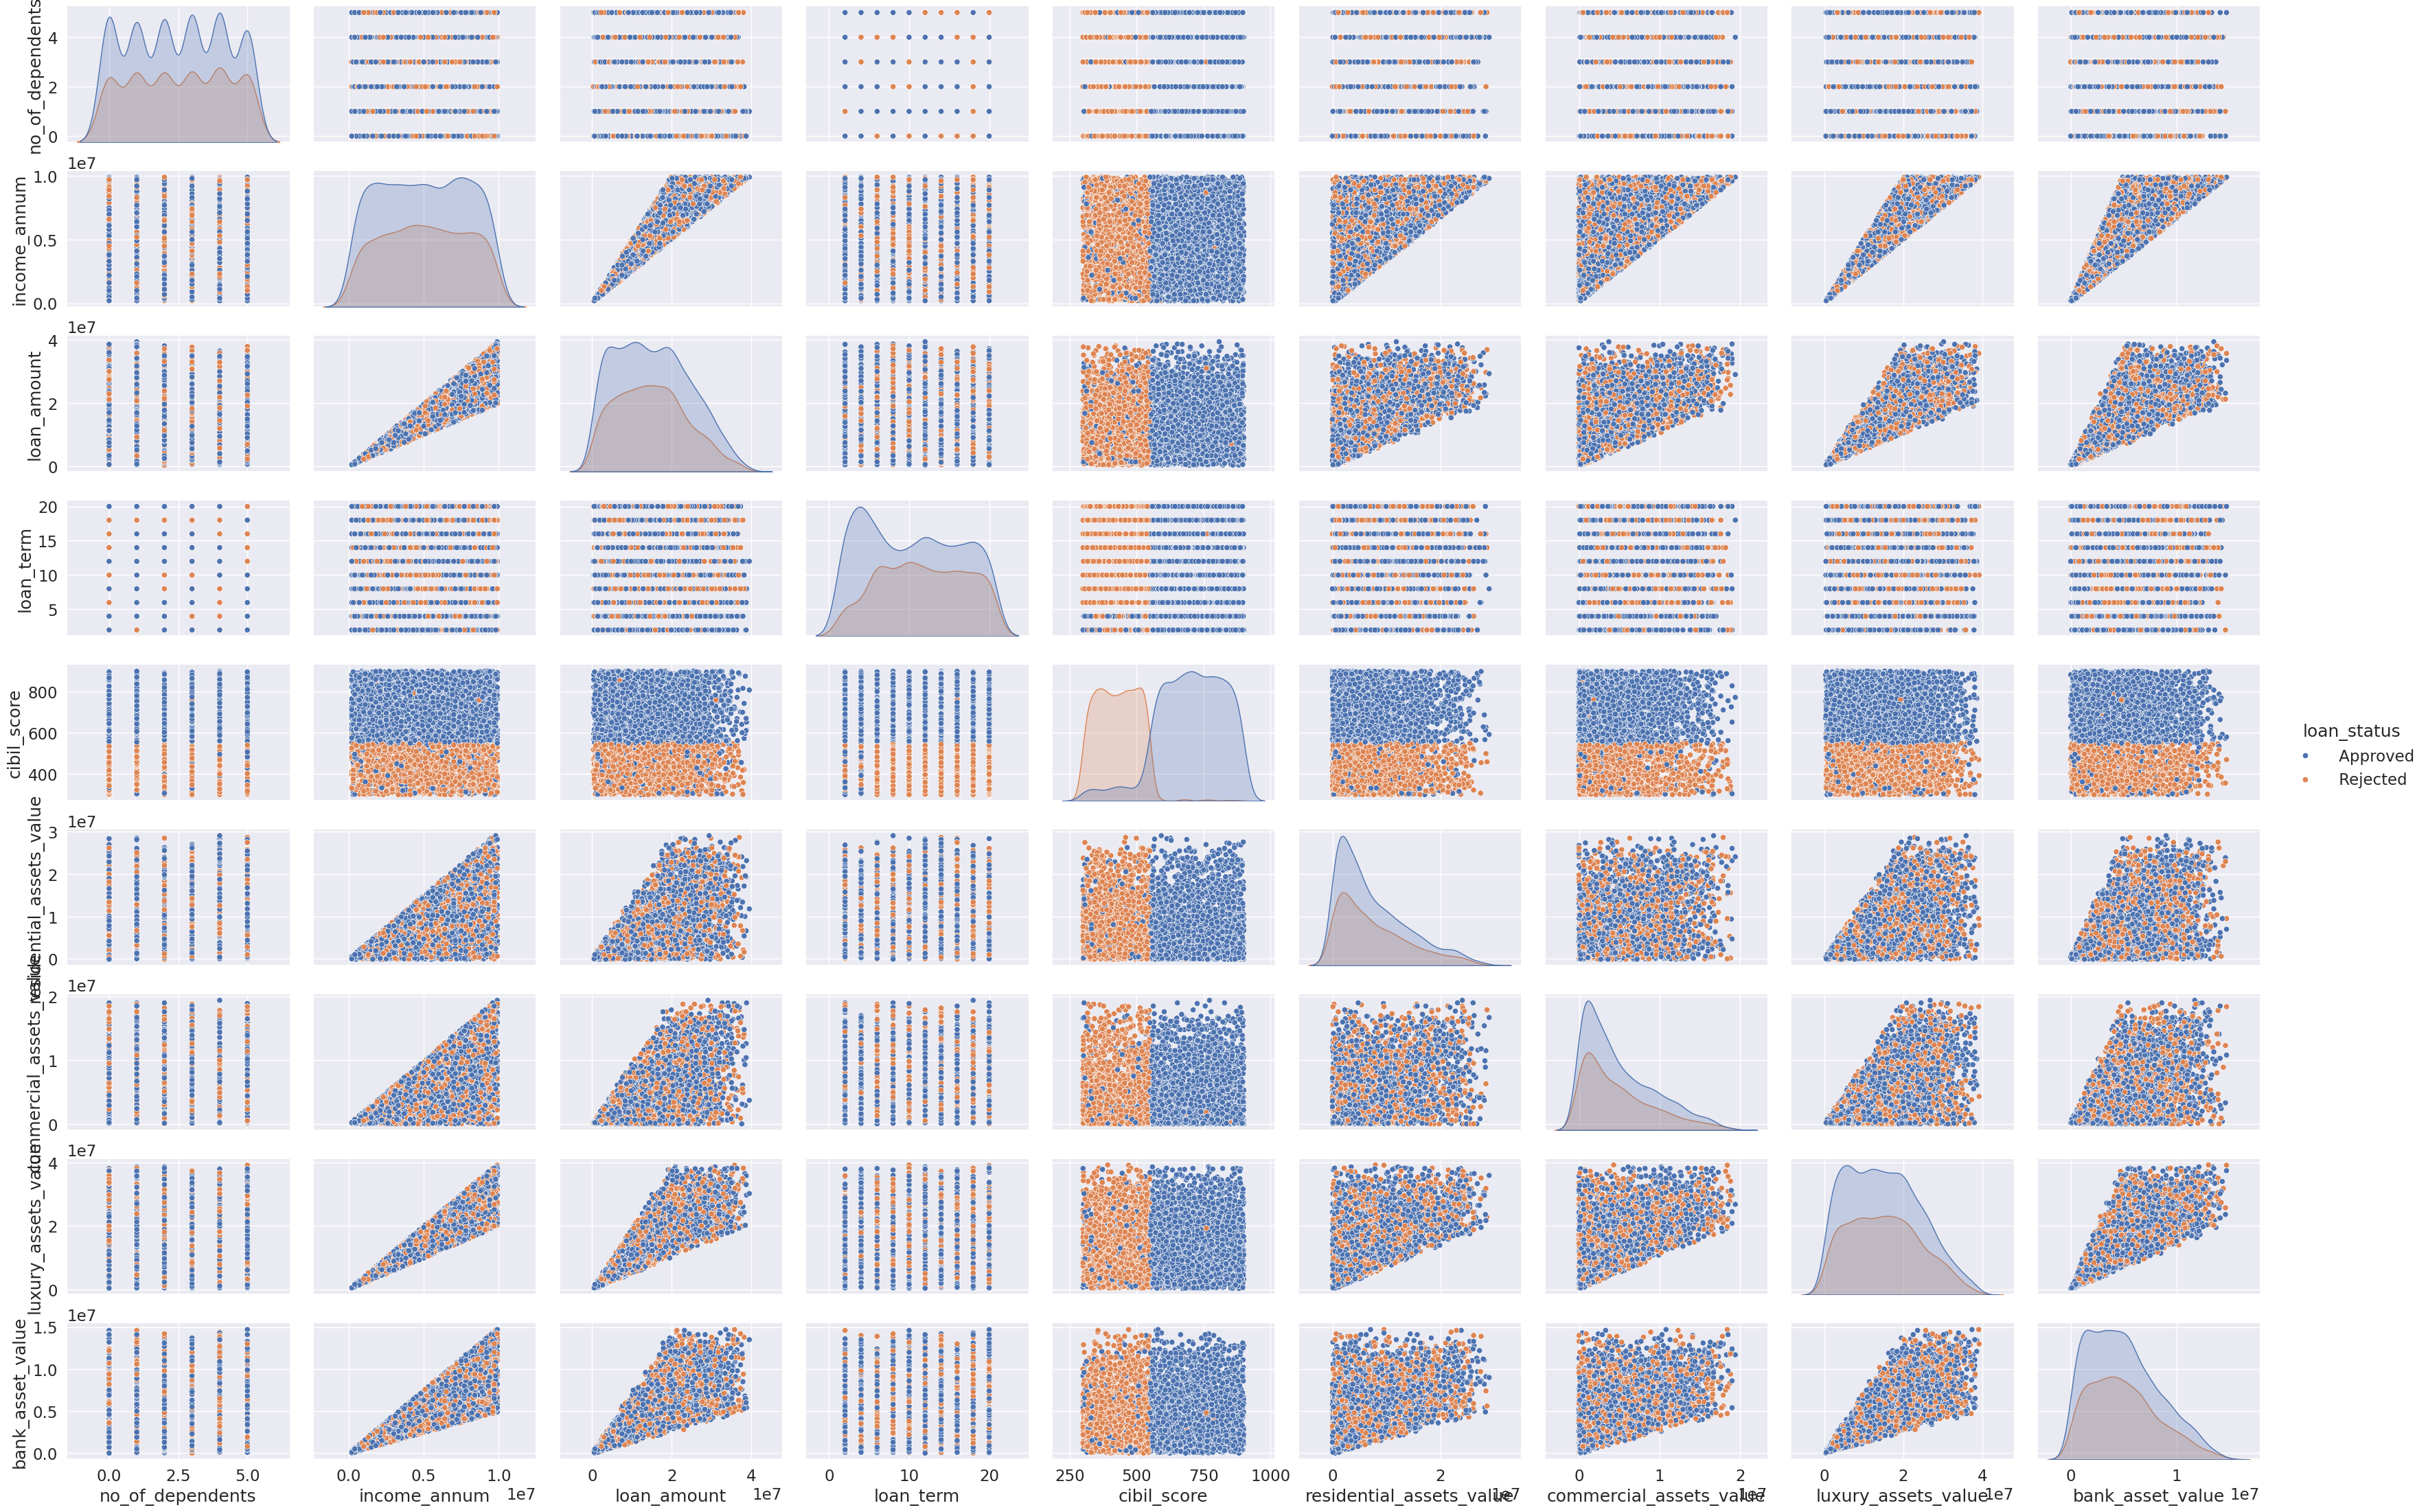

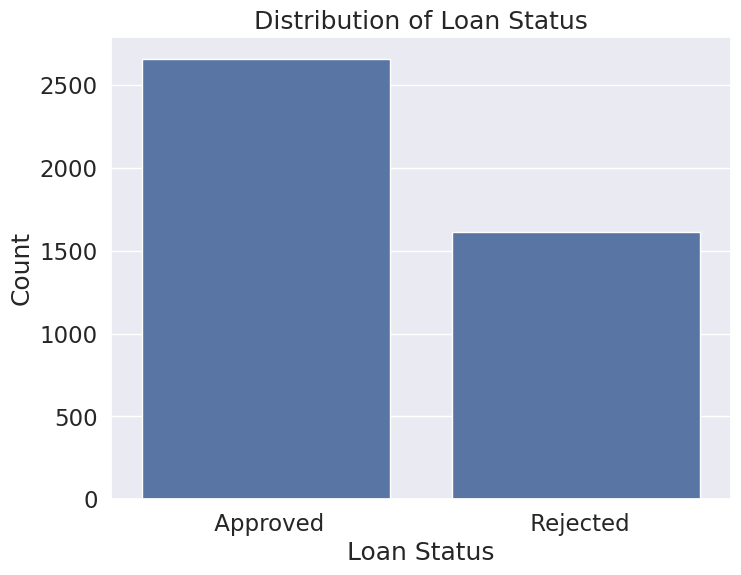

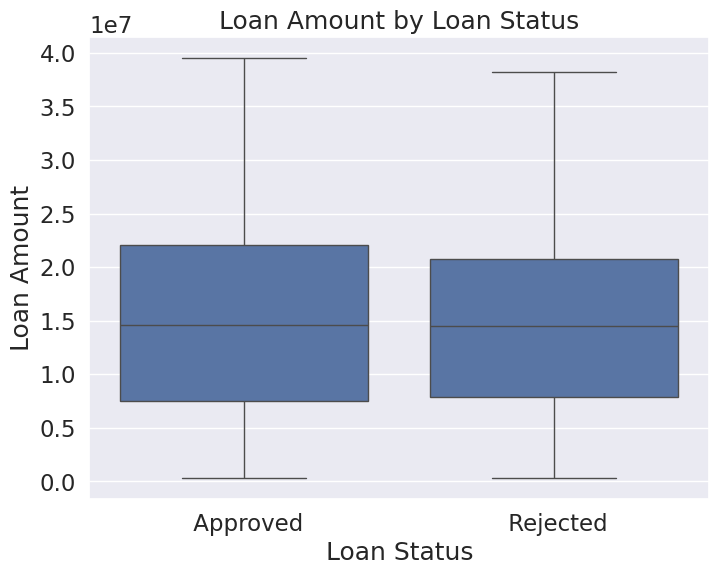

In [160]:
plt.figure(figsize=(15,8))
mpl.rcParams['font.size'] = 16
aspect_ratio = 1.5 
sns.pairplot(data=data,hue='loan_status',aspect=aspect_ratio)

# Plot 2: Bar plot of loan_status
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=data)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Plot 2: Box plot of loan_amount by loan_status
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_status', y='loan_amount', data=data)
plt.title('Loan Amount by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
for head in data.columns:
    if(data[head].dtype == 'object'):
        print(data[head].value_counts(normalize=True))
        print("\n")
data['total_assets']=data['residential_assets_value']+data['commercial_assets_value']+data['bank_asset_value']+data['luxury_assets_value']
print(data['total_assets'].describe())
print(data['income_annum'].describe())
scaler_viz = MinMaxScaler()
data_vis=pd.DataFrame()
data_vis[['total_assets','income_annum']]=scaler_viz.fit_transform(data[['total_assets','income_annum']])
data_vis['loan_to_wealth']=data['loan_amount']/(data['total_assets']+data['income_annum'])
plt.figure(figsize=(16,9))
sns.stripplot(x=data['self_employed'],y=data_vis['loan_to_wealth'],hue=data['loan_status'],dodge=True,jitter=0.2,alpha=0.8)
plt.ylabel('loan_to_wealth ratio')


In [116]:
# Encode categorical features using one-hot encoding
from sklearn.preprocessing import LabelEncoder
labeler=LabelEncoder()
data['education']=labeler.fit_transform(data['education'])
data['self_employed']=labeler.fit_transform(data['self_employed'])
# create a new feature 'total_assets_value' which sums up all asset values
data['total_assets']=data['residential_assets_value']+data['commercial_assets_value']+data['bank_asset_value']+data['luxury_assets_value']
data['loan_to_wealth']=data['loan_amount']/(data['total_assets']+data['income_annum'])
# Drop the individual asset value columns as they are now redundant
data.drop(['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value','loan_amount','income_annum'], axis=1, inplace=True)
# Scale numerical features
scaler = StandardScaler()
data[data.drop('loan_status',axis=1).columns.values] = scaler.fit_transform(data.drop('loan_status',axis=1))

# Handle missing values (there are none in this dataset)

# Outlier detection
z_scores = stats.zscore(data.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]



In [ ]:


#see the result of feature engineering

plt.figure(figsize=(8, 6))
sns.violinplot(x='loan_status', y='total_assets', data=data)
plt.title('Total Assets by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Total Assets')
plt.show()

# Plot 4: Scatter plot of total asset ratio to loan amount vs. income ratio to loan amount
total_asset_ratio = total_assets / data['loan_amount']
income_ratio = data['income_annum'] / data['loan_amount']

plt.figure(figsize=(8, 6))
sns.scatterplot(x=total_asset_ratio, y=income_ratio, hue='loan_status', data=data)
plt.title('Total Asset Ratio vs. Income Ratio to Loan Amount')
plt.xlabel('Total Asset Ratio to Loan Amount')
plt.ylabel('Income Ratio to Loan Amount')
plt.show()

# Plot 5: Violin plot of income ratio to loan amount by loan_status
plt.figure(figsize=(8, 6))
sns.violinplot(x='loan_status', y=income_ratio, data=data)
plt.title('Income Ratio to Loan Amount by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Income Ratio to Loan Amount')
plt.show()

In [142]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

dt_classifier = DecisionTreeClassifier(random_state=13)

# Fit the classifier to the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=' Approved')
recall = recall_score(y_test, y_pred, pos_label=' Approved')
f1 = f1_score(y_test, y_pred, pos_label=' Approved')

# Display evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9810874704491725
Precision: 0.9868421052631579
Recall: 0.9831460674157303
F1 Score: 0.9849906191369606


In [134]:
# Define the grid of hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 4, 8, 16],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [2, 3, 5]
}

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=13)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the decision tree classifier with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(random_state=13, **best_params)

# Fit the classifier to the training data with best hyperparameters
best_dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_best = best_dt_classifier.predict(X_test)

# Evaluate model performance with best hyperparameters
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=' Approved')
recall_best = recall_score(y_test, y_pred_best, pos_label=' Approved')
f1_best = f1_score(y_test, y_pred_best, pos_label=' Approved')

# Display evaluation metrics for the model with best hyperparameters
print("Model with Best Hyperparameters:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1 Score:", f1_best)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Model with Best Hyperparameters:
Accuracy: 0.9822695035460993
Precision: 0.9796672828096118
Recall: 0.9925093632958801
F1 Score: 0.986046511627907


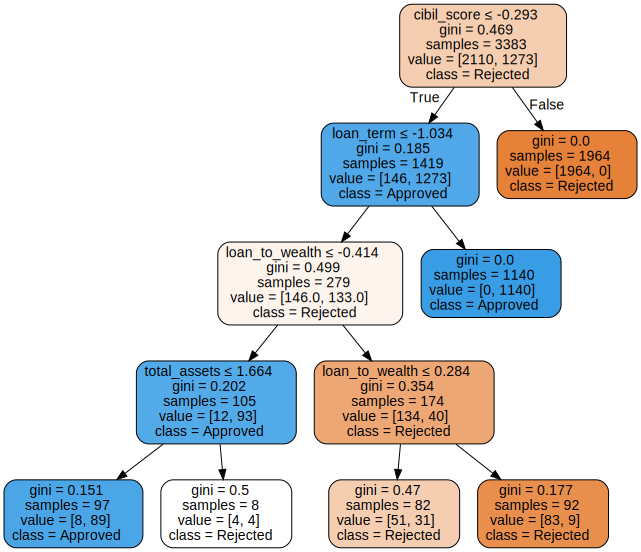

In [139]:
# Export the decision tree as a DOT file
dot_data = export_graphviz(best_dt_classifier, out_file=None,
                           feature_names=X.columns,
                           class_names=['Rejected', 'Approved'],
                           filled=True, rounded=True, special_characters=True)

# Visualize the decision tree using graphviz
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('decision_tree', view=True)

# display graph
graph

In [140]:
# Save the unpruned decision tree graph as a PNG file
graph.render('./Pictures/tree.png', format='png', cleanup=True)


'Pictures/tree.png.png'

In [156]:
# Initialize the decision tree classifier with pruning parameters
pruned_dt_classifier = DecisionTreeClassifier(random_state=13, max_depth=3, min_samples_split=2, min_samples_leaf=2)

# Fit the pruned decision tree classifier to the training data
pruned_dt_classifier.fit(X_train, y_train)

# Predict on the test data using the pruned decision tree
y_pred_pruned = pruned_dt_classifier.predict(X_test)

# Evaluate model performance with pruning
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
precision_pruned = precision_score(y_test, y_pred_pruned, pos_label=' Approved')
recall_pruned = recall_score(y_test, y_pred_pruned, pos_label=' Approved')
f1_pruned = f1_score(y_test, y_pred_pruned, pos_label=' Approved')

# Display evaluation metrics for the pruned model
print("Pruned Decision Tree Model Performance:")
print("Accuracy:", accuracy_pruned)
print("Precision:", precision_pruned)
print("Recall:", recall_pruned)
print("F1 Score:", f1_pruned)

Pruned Decision Tree Model Performance:
Accuracy: 0.9799054373522459
Precision: 0.9813780260707635
Recall: 0.9868913857677902
F1 Score: 0.9841269841269841


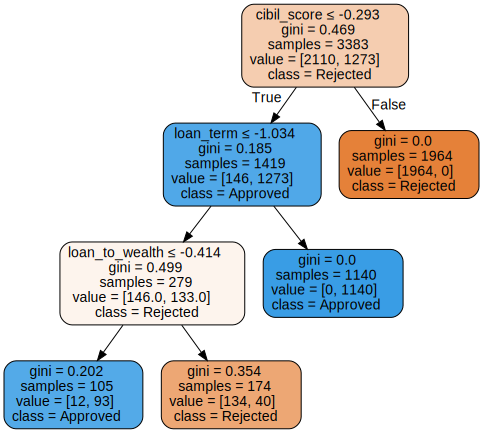

In [157]:
# Export the pruned decision tree as a DOT file
dot_data_pruned = export_graphviz(pruned_dt_classifier, out_file=None,
                                   feature_names=X.columns,
                                   class_names=['Rejected', 'Approved'],
                                   filled=True, rounded=True, special_characters=True)

# Visualize the pruned decision tree using graphviz
graph_pruned = graphviz.Source(dot_data_pruned)
graph_pruned.format = 'png'
graph_pruned.render('pruned_decision_tree', view=True)

# display graph
graph_pruned

In [138]:
# Save the pruned decision tree graph as a PNG file
graph_pruned.render('./Pictures/pruned_decision_tree', format='png', cleanup=True)


'Pictures/pruned_decision_tree.png'